<a href="https://colab.research.google.com/github/kk20krishna/X-ray-image-Classification/blob/main/X_ray_image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt

In [44]:
import kagglehub

# Download latest version
#path = kagglehub.dataset_download("kk20krishna/cxr-data")
path = kagglehub.dataset_download("nih-chest-xrays/data")

print("Path to dataset files:", path)

  7%|▋         | 3.13G/42.0G [00:54<11:20, 61.3MB/s]


KeyboardInterrupt: 

In [3]:
# List the contents of the dataset folder
dataset_files = os.listdir(path)
print("Files in dataset folder:", dataset_files)

Files in dataset folder: ['nofinding', 'effusion']


Found 1107 files belonging to 2 classes.
(32, 256, 256, 3) (32,)


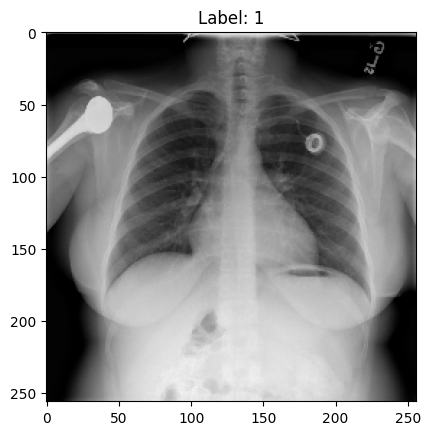

In [4]:
dataset = keras.utils.image_dataset_from_directory(path)

# Get the images from the dataset
dataset.batch(1)
for image, label in dataset.take(1):
  print(image.shape, label.shape)
  first_image = image[0].numpy()
  first_label = label[0].numpy()
  #display image


  plt.imshow(first_image.astype('uint8')) # Ensure correct display
  plt.title(f"Label: {first_label}")
  plt.show()

In [37]:
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(path,
                                                   label_mode='categorical',
                                                   validation_split=0.8,
                                                   subset="both",
                                                   image_size=(224, 224),
                                                   seed=44,)

Found 1107 files belonging to 2 classes.
Using 222 files for training.
Using 885 files for validation.


In [38]:
train_dataset.class_names

['effusion', 'nofinding']

In [39]:
# prompt: determine class weight from train_dataset

import numpy as np

class_counts = np.zeros(len(train_dataset.class_names))
for images, labels in train_dataset:
    for label in labels:
        class_counts[np.argmax(label)] += 1

print(class_counts)

total_samples = np.sum(class_counts)
class_weights = {}
for i, count in enumerate(class_counts):
    class_weights[i] = total_samples / (len(train_dataset.class_names) * count)

print("Class Weights:", class_weights)

[ 28. 194.]
Class Weights: {0: 3.9642857142857144, 1: 0.5721649484536082}


In [40]:
from sklearn.utils.class_weight import compute_class_weight

In [41]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

In [42]:
# prompt: get ResNet50V2, exclude top, freeze all layers, flatten, add two dense layers, add final layer with 2 outputs and softmax activation

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load the pre-trained ResNet50V2 model without the top classification layer
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model (you can adjust the optimizer, loss, and metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC', 'precision', 'recall'])

# Print the model summary to see the architecture
model.summary(show_trainable=True)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_7          │ (None, 224, 224, 3)  │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv1_pad              │ (None, 230, 230, 3)  │            0 │ input_layer_7[0][0] │    -    │
│ (ZeroPadding2D)        │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv1_conv (Conv2D)    │ (None, 112, 112, 64) │        9,472 │ conv1_pad[0][0]     │    N    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ pool1_pad              │ (None, 114, 114, 64) │            0 │ conv1_conv[0][0]    │    -    │
│ (ZeroPadding2D)        │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ pool1_pool             │ (None, 56, 56, 64)   │            0 │ pool1_pad[0][0]     │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_preact_bn │ (None, 56, 56, 64)   │          256 │ pool1_pool[0][0]    │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_preact_r… │ (None, 56, 56, 64)   │            0 │ conv2_block1_preac… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_1_conv    │ (None, 56, 56, 64)   │        4,096 │ conv2_block1_preac… │    N    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_1_bn      │ (None, 56, 56, 64)   │          256 │ conv2_block1_1_con… │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_1_relu    │ (None, 56, 56, 64)   │            0 │ conv2_block1_1_bn[… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_2_pad     │ (None, 58, 58, 64)   │            0 │ conv2_block1_1_rel… │    -    │
│ (ZeroPadding2D)        │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_2_conv    │ (None, 56, 56, 64)   │       36,864 │ conv2_block1_2_pad… │    N    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_2_bn      │ (None, 56, 56, 64)   │          256 │ conv2_block1_2_con… │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_2_relu  

 Total params: 126,852,098 (483.90 MB)

 Trainable params: 103,287,298 (394.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [43]:
model.fit(train_dataset, epochs=2, validation_data=val_dataset, class_weight=class_weights)

Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 264s 41s/step - accuracy: 0.5224 - loss: 3604.6543 - val_accuracy: 0.9107 - val_loss: 208.5247
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 259s 40s/step - accuracy: 0.4813 - loss: 1751.9517 - val_accuracy: 0.9107 - val_loss: 457.0417


class_names:  ['effusion', 'nofinding']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
predictions:  [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


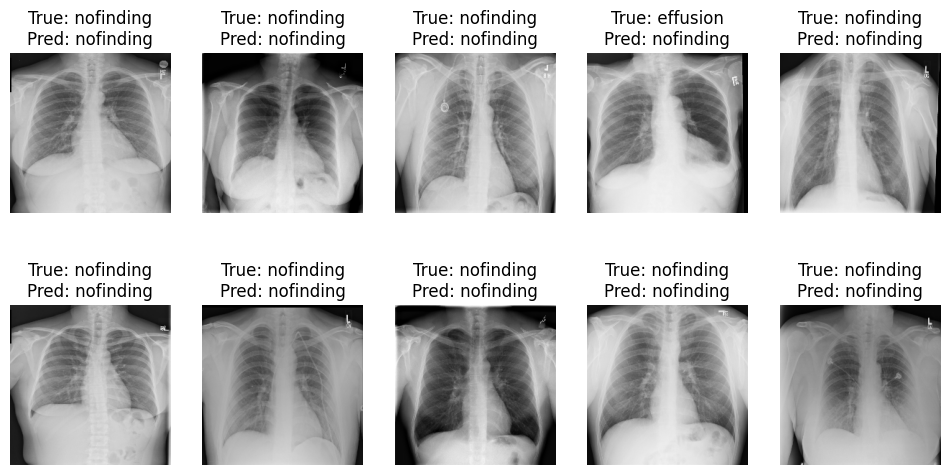

In [ ]:
# Define class names from dataset
class_names = val_dataset.class_names  # Get class labels from dataset
print("class_names: ", class_names)

# Take 10 images from val_dataset
num_images = 10
for images, labels in val_dataset.take(1):  # Take one batch
    images = images[:num_images]  # Select first 10 images
    labels = labels[:num_images]  # Corresponding labels

    # Make predictions
    predictions = model.predict(images)  # Get predicted probabilities
    print("predictions: ", predictions)
    predicted_classes = np.argmax(predictions, axis=1)  # Convert to class index
    true_classes = np.argmax(labels.numpy(), axis=1)  # Convert one-hot labels to index

    # Display images, true labels, and predicted labels
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)  # Arrange in 2 rows of 5 images
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}")
        plt.axis("off")  # Hide axes

    plt.show()